In [1]:
from features import *
from tqdm import tqdm_notebook
import wfdb
import pandas as pd
import numpy as np
import os

%matplotlib inline
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/numba/errors.py:105: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)


# Load data

In [2]:
def process_header_file(file):
    # The clinical variables are added as comments in the
    # .hea file. Extract them from that file.
    start_idx = 0
    with open(file, 'r') as ifp:
        lines = ifp.readlines()
        for line_idx, line in enumerate(lines):
            if line.startswith('#'):
                start_idx = line_idx
                break
        
        names = []
        values = []
        for line in lines[start_idx+1:]:
            _, name, value = line.split()
            names.append(name)
            values.append(value)
            
        return names, values

In [3]:
signals = []
gestations = []
remaining_durations = []
ids = []

for file in tqdm_notebook(set(map(lambda x: x.split('.')[0], os.listdir('data/tpehgdb')))):
    ids.append(file)
    file_path = 'data/tpehgdb/{}'.format(file)

    record = wfdb.rdrecord(file_path)
    
    clin_names, clin_values = process_header_file(file_path + '.hea')
    gestation = float(clin_values[1])
    rectime = float(clin_values[2])
    remaining_duration = gestation - rectime
    
    signal_ch1 = record.p_signal[:, 2]
    signal_ch2 = record.p_signal[:, 6]
    signal_ch3 = record.p_signal[:, 10]
    
    if len(signal_ch1) < 33000: # Faulty signal
        continue
    
    signals.append([signal_ch1, signal_ch2, signal_ch3])
    gestations.append(gestation)
    remaining_durations.append(remaining_duration)

# Peak Frequency

In [105]:
def peak_freq(data, fs):
    ps = np.abs(np.fft.fft(data))**2
    M = len(ps)
    freqs = np.fft.fftfreq(M, d=1/fs)
    
    mask = freqs >= 0
    freqs = freqs[mask]
    ps = ps[mask]
    
    return np.abs(freqs[np.argmax(ps)])

peak_ch1 = []
peak_ch2 = []
peak_ch3 = []

for (signal_ch1, signal_ch2, signal_ch3) in tqdm_notebook(signals):
    cutoff = len(signal_ch1) - 32768
    signal_ch1 = signal_ch1[int(np.floor(cutoff / 2)):-int(np.ceil(cutoff / 2))]
    signal_ch2 = signal_ch2[int(np.floor(cutoff / 2)):-int(np.ceil(cutoff / 2))]
    signal_ch3 = signal_ch3[int(np.floor(cutoff / 2)):-int(np.ceil(cutoff / 2))]
    peak_ch1.append(peak_freq(signal_ch1, 20.0))
    peak_ch2.append(peak_freq(signal_ch2, 20.0))
    peak_ch3.append(peak_freq(signal_ch3, 20.0))

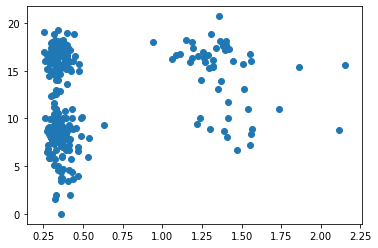

In [106]:
plt.scatter(peak_ch1, remaining_durations)

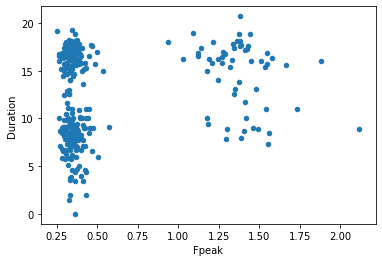

In [107]:
# Let's check if this matches the feature file

df = pd.read_csv('data/features/tpehgdb_features__filter_0.3_Hz-3.0_Hz.fvl')
df['Duration'] = df['Gestation'] - df['Rec. time']
df[df['Chann'] == 1][['Fpeak', 'Duration']].plot(kind='scatter', x='Fpeak', y='Duration')

# Median Frequency

In [104]:
def median_freq(data, fs):
    ps = np.abs(np.fft.fft(data))**2
    M = len(ps)
    freqs = np.fft.fftfreq(M, d=1/fs)
    
    mask = freqs >= 0
    freqs = freqs[mask]
    ps = ps[mask]
    
    best_k, min_dist = None, float('inf')
    
    # Divide-and-conquer on array of positive values to find
    # index that partitions the array into parts with
    # an as equal sum as possible
    k = len(ps) // 2
    offset = len(ps) // 4
    while offset > 0:
        sum1 = np.sum(ps[:k])
        sum2 = np.sum(ps[k:])
        d = abs(sum1 - sum2)
            
        if d < min_dist:
            min_dist = d
            best_k = k
        
        if sum1 > sum2:
            k -= offset
        else:
            k += offset
            
        offset = offset // 2
            
    return freqs[best_k]

med_ch1 = []
med_ch2 = []
med_ch3 = []

for (signal_ch1, signal_ch2, signal_ch3) in tqdm_notebook(signals):
    cutoff = len(signal_ch1) - 32768
    signal_ch1 = signal_ch1[int(np.floor(cutoff / 2)):-int(np.ceil(cutoff / 2))]
    signal_ch2 = signal_ch2[int(np.floor(cutoff / 2)):-int(np.ceil(cutoff / 2))]
    signal_ch3 = signal_ch3[int(np.floor(cutoff / 2)):-int(np.ceil(cutoff / 2))]
    med_ch1.append(median_freq(signal_ch1, 20.0))
    med_ch2.append(median_freq(signal_ch2, 20.0))
    med_ch3.append(median_freq(signal_ch3, 20.0))

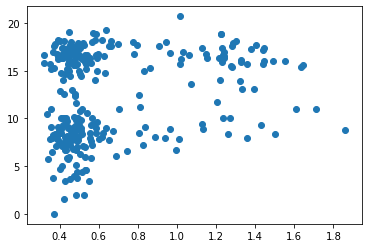

In [102]:
plt.scatter(med_ch1, remaining_durations)

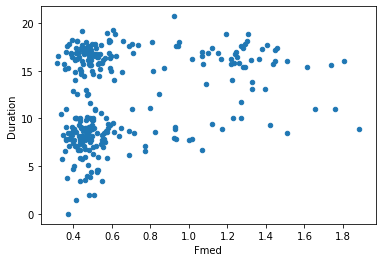

In [103]:
# Let's check if this matches the feature file

df = pd.read_csv('data/features/tpehgdb_features__filter_0.3_Hz-3.0_Hz.fvl')
df['Duration'] = df['Gestation'] - df['Rec. time']
df[df['Chann'] == 1][['Fmed', 'Duration']].plot(kind='scatter', x='Fmed', y='Duration')

# Root Mean Squared

In [29]:
def rms(signal):
    return np.sqrt(np.mean(signal[3000:-3000] ** 2)) * 1000

rms_ch1 = []
rms_ch2 = []
rms_ch3 = []

for (signal_ch1, signal_ch2, signal_ch3) in tqdm_notebook(signals):
    rms_ch1.append(rms(signal_ch1))
    rms_ch2.append(rms(signal_ch2))
    rms_ch3.append(rms(signal_ch3))

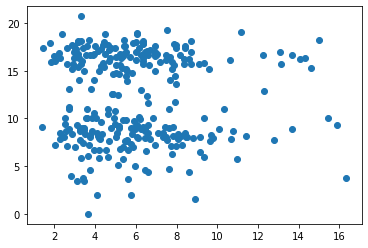

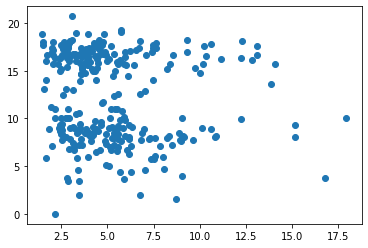

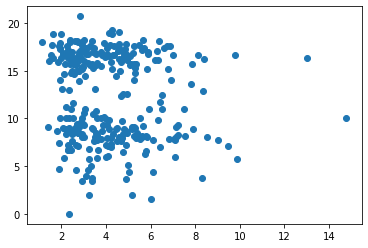

In [30]:
plt.figure()
plt.scatter(rms_ch1, remaining_durations)
plt.show()

plt.figure()
plt.scatter(rms_ch2, remaining_durations)
plt.show()

plt.figure()
plt.scatter(rms_ch3, remaining_durations)
plt.show()

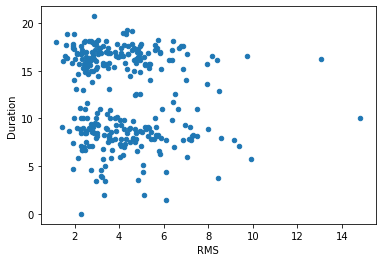

In [31]:
# Let's check if this matches the feature file

df = pd.read_csv('data/features/tpehgdb_features__filter_0.3_Hz-3.0_Hz.fvl')
df['Duration'] = df['Gestation'] - df['Rec. time']
df[df['Chann'] == 3][['RMS', 'Duration']].plot(kind='scatter', x='RMS', y='Duration')

# Sample Entropy

In [76]:
sampen_ch1 = []
sampen_ch2 = []
sampen_ch3 = []

for _id, (signal_ch1, signal_ch2, signal_ch3) in tqdm_notebook(list(zip(ids, signals))):
    sampen_ch1.append(app_entropy(signal_ch1[3000:-3000], 2, r=0.15))
    sampen_ch2.append(app_entropy(signal_ch2[3000:-3000], 2, r=0.15))
    sampen_ch3.append(app_entropy(signal_ch3[3000:-3000], 2, r=0.15))

In [ ]:
plt.figure()
plt.scatter(sampen_ch1, remaining_durations)
plt.show()

plt.figure()
plt.scatter(sampen_ch2, remaining_durations)
plt.show()

plt.figure()
plt.scatter(sampen_ch3, remaining_durations)
plt.show()

In [ ]:
# Let's check if this matches the feature file
provided_sampen = []
df = pd.read_csv('data/features/tpehgdb_features__filter_0.3_Hz-3.0_Hz.fvl')
for _id in ids:
    provided_sampen.append(df[(df['Record'] == ' '+_id) & (df['Chann'] == 1)].iloc[0, :]['Samp. en.'])
    
plt.figure()
plt.scatter(sampen_ch1, provided_sampen)
plt.show()

# Fuzzy Sample Entropy

# Autocorrelation zero-crossing

In [22]:
import statsmodels.api as sm

def ac_zero_crossing(signal):
    tau = sm.tsa.acf(signal, nlags=len(signal) - 1)
    tau_neg_ix = np.arange(len(tau), dtype=int)[tau < 0]
    return tau_neg_ix[0]

ac_zero_ch1 = []
ac_zero_ch2 = []
ac_zero_ch3 = []

for _id, (signal_ch1, signal_ch2, signal_ch3) in tqdm_notebook(list(zip(ids, signals))):
#     print(ac_zero_crossing(signal_ch1[3000:-3000]), Tao(signal_ch1[3000:-3000]))
    ac_zero_ch1.append(ac_zero_crossing(signal_ch1[3000:-3000]))
    ac_zero_ch2.append(ac_zero_crossing(signal_ch2[3000:-3000]))
    ac_zero_ch3.append(ac_zero_crossing(signal_ch3[3000:-3000]))

KeyboardInterrupt: 

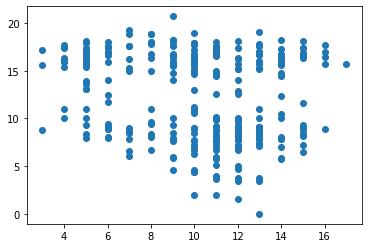

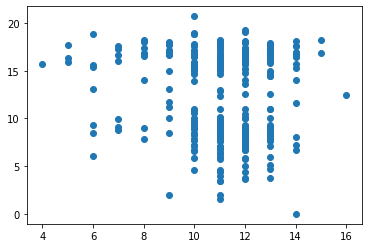

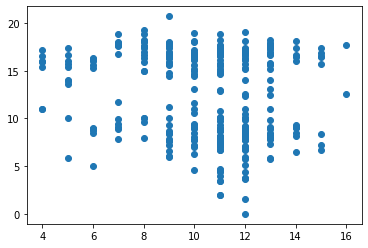

In [8]:
plt.figure()
plt.scatter(ac_zero_ch1, remaining_durations)
plt.show()

plt.figure()
plt.scatter(ac_zero_ch2, remaining_durations)
plt.show()

plt.figure()
plt.scatter(ac_zero_ch3, remaining_durations)
plt.show()

# Maximal Lyapunov Exponent (Rosenstein algorithm)

In [67]:
# # Warning: very memory-intensive (and untested)

from nolitsa.lyapunov import mle_embed
lyap_ch1 = []

for i, (_id, (signal_ch1, signal_ch2, signal_ch3)) in tqdm_notebook(enumerate(list(zip(ids, signals)))):
    y = mle_embed(signal_ch1[3000:-3000], [7], ac_zero_ch1[i], maxt=10)[0]
    x = np.arange(len(y))
    
    lyap_ch1.append(np.polyfit(x, y, 1)[0])
    
    if i == 50:
        break

# from nolds import lyap_r

# lyap_ch1 = []
# lyap_ch2 = []
# lyap_ch3 = []

# for i, (_id, (signal_ch1, signal_ch2, signal_ch3)) in tqdm_notebook(enumerate(list(zip(ids, signals)))):
#     lyap_ch1.append(lyap_r(signal_ch1[3000:-3000], emb_dim=7, lag=ac_zero_ch1[i]))
# #     lyap_ch2.append(lyap_r(signal_ch2[3000:-3000], emb_dim=7))
# #     lyap_ch3.append(lyap_r(signal_ch3[3000:-3000], emb_dim=7))

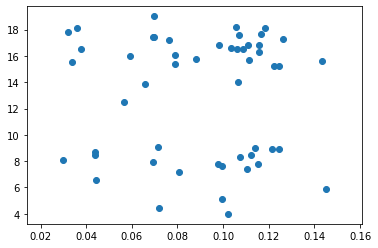

In [69]:
plt.scatter(lyap_ch1, remaining_durations[:len(lyap_ch1)])

In [75]:
from scipy.stats import ttest_ind

preterm_early = []
preterm_late = []
term_early = []
term_late = []
for gest, dur, lyap in zip(gestations, remaining_durations, lyap_ch1):
    if gest - dur <= 26:
        if gest >= 37:
            term_early.append(lyap)
        else:
            preterm_early.append(lyap)
    else:
        if gest >= 37:
            term_late.append(lyap)
        else:
            preterm_late.append(lyap)
        
print(term_early, preterm_early)
# print(preterm_early, preterm_late)
print(ttest_ind(preterm_early, term_early))
print(ttest_ind(preterm_late, term_late))

[0.07636514121070026, 0.03753511398971444, 0.11664880991674756, 0.11574228511630294, 0.1155161656178812, 0.122099320024579, 0.07874904688085868, 0.11821316283950492, 0.06935200581700789, 0.03583276107209364, 0.07904565280227613, 0.10326053861388455, 0.10686090936957286, 0.06557340738083876, 0.10617301437438599, 0.10572641187713881, 0.10660909027242546, 0.03217646810131801, 0.09835845604979321, 0.1086106623916583, 0.06983710662317956, 0.14329808359400384, 0.12609170056909935, 0.12442956146377533, 0.111448374818167, 0.11080055683918429, 0.06957744704696915, 0.05940640356203463, 0.033963199185111245, 0.08806569255551784] [0.056678753409447245]
Ttest_indResult(statistic=nan, pvalue=nan)
Ttest_indResult(statistic=1.0182574685644485, pvalue=0.32204764092907423)


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3157: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


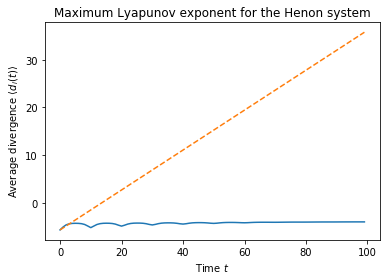

In [57]:
from nolitsa import data, lyapunov
import numpy as np
import matplotlib.pyplot as plt

x = data.henon(length=5000)[:, 0]

# Time delay.
tau = 1

# Embedding dimension.
dim = [2]

d = lyapunov.mle_embed(signals[0][0][3000:-3000], [7], ac_zero_ch1[0], maxt=100)[0]
t = np.arange(100)

plt.title('Maximum Lyapunov exponent for the Henon system')
plt.xlabel(r'Time $t$')
plt.ylabel(r'Average divergence $\langle d_i(t) \rangle$')
plt.plot(t, d)
plt.plot(t, t * 0.419 + d[0], '--')

plt.show()

In [66]:
d, [-4.6353 + 0.00746983 * i for i in range(len(d))]

(array([-5.6933378 , -5.07687887, -4.62621846, -4.4136014 , -4.32676548,
        -4.30455226, -4.31970012, -4.38715393, -4.55070124, -4.86914167,
        -5.21385101, -4.87879598, -4.55481577, -4.38220785, -4.3073089 ,
        -4.28620795, -4.29663252, -4.34930492, -4.47474067, -4.6987408 ,
        -4.89639438, -4.70344734, -4.47312709, -4.33744615, -4.27636738,
        -4.25815927, -4.26447889, -4.30173728, -4.39116753, -4.5392661 ,
        -4.64965372, -4.53410337, -4.37696353, -4.27515781, -4.22651227,
        -4.21045296, -4.21489258, -4.24233688, -4.30552808, -4.40252817,
        -4.46549391, -4.39614919, -4.28897957, -4.2138906 , -4.17726028,
        -4.16464146, -4.16786521, -4.18751615, -4.22951177, -4.28841652,
        -4.3223096 , -4.28173589, -4.21347203, -4.16173524, -4.1345971 ,
        -4.12375852, -4.1235561 , -4.13263234, -4.15365542, -4.1810184 ,
        -4.1951181 , -4.17609025, -4.14113638, -4.11186794, -4.09496346,
        -4.08614116, -4.0828768 , -4.08263369, -4.0

In [60]:
np.polyfit(np.arange(len(d)), d, 1)

array([ 0.00746983, -4.63537716])

# Correlation dimension

In [43]:
from nolitsa.d2 import c2_embed, d2

corr_ch1 = []
corr_ch2 = []
corr_ch3 = []

for i, (_id, (signal_ch1, signal_ch2, signal_ch3)) in tqdm_notebook(enumerate(list(zip(ids, signals)))):
    r, C_r = c2_embed(signal_ch1[3000:-3000], [7], ac_zero_ch1[i])[0]
    print(r[:7], C_r[:7])
    corr_ch1.append(d2(r[:7], C_r[:7])[0])
    if i == 10:
        break
#     corr_ch1.append(Dim_Corr(signal_ch1[3000:-3000], ac_zero_ch1[0], 7))
#     corr_ch2.append(corr_dim(signal_ch2[3000:-3000], 7))
#     corr_ch3.append(corr_dim(signal_ch3[3000:-3000], 7))

[0.00024386 0.00026149 0.00028038 0.00030065 0.00032237 0.00034567
 0.00037065] [4.68184702e-09 4.68184702e-09 4.68184702e-09 4.68184702e-09
 4.68184702e-09 4.68184702e-09 4.68184702e-09]


/usr/local/lib/python3.6/dist-packages/nolitsa/d2.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  d[i] = np.linalg.lstsq(A, q)[0][0]


[0.00053963 0.00057863 0.00062044 0.00066528 0.00071336 0.00076491
 0.00082019] [1.17318949e-08 1.17318949e-08 3.98884428e-08 3.98884428e-08
 9.85479176e-08 2.34637899e-07 2.34637899e-07]
[0.0004781  0.00051266 0.0005497  0.00058943 0.00063203 0.0006777
 0.00072668] [2.23808442e-09 2.23808442e-09 2.23808442e-09 2.23808442e-09
 4.47616883e-09 4.47616883e-09 4.47616883e-09]
[0.00031649 0.00033936 0.00036389 0.00039018 0.00041838 0.00044862
 0.00048104] [6.70617474e-09 6.70617474e-09 6.70617474e-09 1.34123495e-08
 1.34123495e-08 1.34123495e-08 6.70617474e-08]
[0.00031574 0.00033856 0.00036302 0.00038926 0.00041739 0.00044755
 0.0004799 ] [8.94874506e-09 8.94874506e-09 8.94874506e-09 4.02693528e-08
 4.02693528e-08 4.02693528e-08 9.39618231e-08]


Process ForkPoolWorker-149:
Process ForkPoolWorker-151:
Process ForkPoolWorker-152:
Process ForkPoolWorker-150:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/lib/python3.6/multiprocessing/pool.py", l

KeyboardInterrupt: 

  File "/usr/lib/python3.6/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/usr/local/lib/python3.6/dist-packages/nolitsa/d2.py", line 95, in c2
    c += np.histogram(dists, bins=bins)[0]
  File "/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py", line 795, in histogram
    sa = np.sort(a[i:i+BLOCK])
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py", line 878, in sort
    a.sort(axis=axis, kind=kind, order=order)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
KeyboardInterrupt
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
KeyboardInterrupt


In [68]:
corr_ch1

[array([6.10611864e-15]),
 array([8.1297272]),
 array([2.12871211]),
 array([4.60007034]),
 array([5.92020641])]

In [5]:
def logarithmic_r(min_n, max_n, factor):
    """
    Creates a list of values by successively multiplying a minimum value min_n by
    a factor > 1 until a maximum value max_n is reached.

    Args:
    min_n (float):
      minimum value (must be < max_n)
    max_n (float):
      maximum value (must be > min_n)
    factor (float):
      factor used to increase min_n (must be > 1)

    Returns:
    list of floats:
      min_n, min_n * factor, min_n * factor^2, ... min_n * factor^i < max_n
    """
    assert max_n > min_n
    assert factor > 1
    max_i = int(np.floor(np.log(1.0 * max_n / min_n) / np.log(factor)))
    return [min_n * (factor ** i) for i in range(max_i + 1)]

sd = np.std(signals[0][0][3000:-3000])
print(sd)
logarithmic_r(0.1 * sd, 0.5 * sd, 1.03)

0.006361917483843214


[0.0006361917483843215,
 0.0006552775008358511,
 0.0006749358258609266,
 0.0006951839006367545,
 0.0007160394176558572,
 0.0007375206001855329,
 0.0007596462181910989,
 0.0007824356047368318,
 0.0008059086728789369,
 0.000830085933065305,
 0.0008549885110572641,
 0.000880638166388982,
 0.0009070573113806515,
 0.0009342690307220711,
 0.0009622971016437333,
 0.0009911660146930453,
 0.0010209009951338368,
 0.0010515280249878518,
 0.0010830738657374875,
 0.001115566081709612,
 0.0011490330641609006,
 0.0011835040560857276,
 0.0012190091777682993,
 0.0012555794531013485,
 0.001293246836694389,
 0.0013320442417952205,
 0.0013720055690490773,
 0.0014131657361205498,
 0.0014555607082041662,
 0.0014992275294502912,
 0.0015442043553338,
 0.0015905304859938137,
 0.0016382464005736284,
 0.0016873937925908373,
 0.0017380156063685622,
 0.0017901560745596193,
 0.001843860756796408,
 0.0018991765795003002,
 0.0019561518768853093,
 0.0020148364331918685,
 0.0020752815261876247,
 0.0021375399719732536,


# Features from "Advanced Artificial Neural Network Classification for Detecting Preterm BirthsUsing EHG Records"

In [ ]:
def sum_absolute_values(signal):
    return np.sum(np.abs(signal))

def mean_abs_value(signal):
    return np.mean(np.abs(signal))

def squared_sum(signal):
    return np.sum(signal)

def wavelet_length(signal):
    return np.sum(np.abs(signal[:-1] - signal[1:]))

def log_detector(signal):
    return np.exp(np.mean(np.log(np.abs(signal))))

def variance(signal):
    return np.var(signal)

def variance_abs(signal):
    return np.var(np.abs(np.power(signal[:-1] - signal[1:], 2)))

def max_fractal_length(signal):
    return np.log(np.sqrt(np.sum(np.power(signal[:-1] - signal[1:], 2))))

def avg_amplitude_change(signal):
    return np.mean(np.abs(signal[:-1] - signal[1:]))